# Design Process Figure

This notebook demonstrates the design process figure example, a simple demonstration of the design process using the flexible subset selection strategy. We can express criteria and approaches as objectives, blend them together, and tune the parameters to create subsets for visualization. This notebook generates *Figure 1* of the paper in three parts: `figures/express.pdf`, `figures/blend.pdf`, and `figures/tune.pdf`. The random dataset generated for the example and the subsets selected can be found in `data/1-designProcess`.

### Imports and Setup

In [10]:
# Standard library
import logging
from pathlib import Path

# Third party
import matplotlib.pyplot as plt
import matplotlib_inline

import numpy as np
import seaborn as sns 

# Local files
import flexibleSubsetSelection as fss

# Initialize notebook settings
sns.set_theme() # set seaborn theme
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # vector plots
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Express

Common or custom criteria or standard approaches can be expressed as objectives which can be selected and used for a visualization. The flexibility of the general strategy means any criteria that can be expressed in terms of a loss function can be employed for subset selection. Here, we demonstrate expressing convex hull, outliers, and distinctness as objectives and applying them for subset selection.

In [24]:
directory = "Fig1-designProcess"           # data directory for this notebook
seed = 123456789                           # random seed for replicability
fss.logger.setup(level = logging.WARNING)  # set logging level for the package

# Create a random blobs dataset to use as our example dataset
dataset = fss.Dataset(name="Random Blobs", 
                      randTypes="blobs", 
                      size=(200, 2), 
                      seed=seed)
dataset.save(directory=Path("..") / "data" / directory)

### Convex Hull Objective

Applying this objective allows us to select the smallest subset that covers the convex hull of the original dataset.

\begin{align*}
\min_{S \in \mathbb{S}} & \quad \|S\| \\
\text{s.t.} & \quad \text{Hull}(S) = 0
\end{align*}

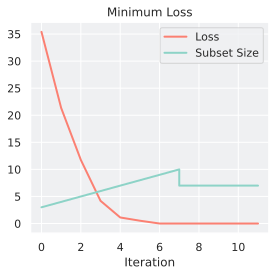

In [12]:
# Precalculate the hull metric on the full dataset
dataset.compute(hull = fss.metric.hull)

# Create a unicriterion loss function with the hull metric and precomputation
lossFunction = fss.UniCriterion(objective = fss.objective.preserveMetric, 
                                metric = fss.metric.hull,
                                datasetMetric = dataset.hull)

# Create a solve method with a greedy algorithm and a set subset size
solver = fss.Solver(algorithm = fss.algorithm.greedyMinSubset, 
                    lossFunction = lossFunction)

# Initialize color and plot settings
color = fss.Color()
fss.plot.initialize(color, font="DejaVu Sans")
lossPlotter = fss.plot.RealTimePlotter(color)

# Solve for a convex hull subset
subsetHull = solver.solve(dataset, 
                          epsilon = 0, 
                          initialSize = 3, 
                          callback = lossPlotter.update)

subsetHull.save(directory=Path("..") / "data" / directory, name="subsetHull")

### Outliers Objective

Applying this objective allows us to select a subset of 40 points with the highest local outlier effect.

\begin{align*}
\max_{S \in \mathbb{S}} & \quad \text{LOF}(S) \\
\text{s.t.} & \quad \|S\| = 40
\end{align*}

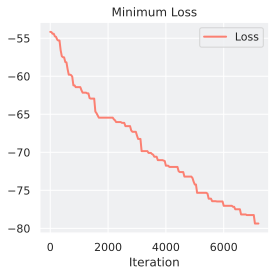

In [13]:
# Precalculate the outlierness (local outlier effect) of the full dataset
dataset.compute(outlierness = fss.objective.outlierness)

# Create a loss function that is just the sum of the LOF in the subset
solver.lossFunction = fss.UniCriterion(objective = np.sum, 
                                       solveArray = "outlierness")
solver.algorithm = fss.algorithm.greedySwap

# Solve for an outlier subset
subsetOutliers = solver.solve(dataset, 
                              subsetSize = 40, 
                              callback = fss.plot.RealTimePlotter(color).update)

subsetOutliers.save(directory = Path("..") / "data" / directory, 
                    name = "outliersSubset")

### Distinctness Objective

Applying this objective allows us to select a subset of 60 points that are distant from their nearest neighbors in 2D space.

\begin{align*}
\max_{S \in \mathbb{S}} & \quad \text{Distinctness}(S) \\
\text{s.t.} & \quad \|S\| = 60
\end{align*}

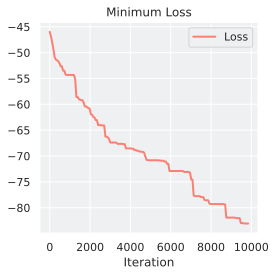

In [14]:
# Create a unicriterion loss function with the distinctness objective
dataset.compute(distances = fss.metric.distanceMatrix)
solver.lossFunction = fss.UniCriterion(objective = fss.objective.distinctness,
                                       solveArray = "distances",
                                       selectBy = "matrix")

# Solve for distinctness subset
subsetDistinct = solver.solve(dataset=dataset, 
                              subsetSize=60, 
                              callback = fss.plot.RealTimePlotter(color).update)
subsetDistinct.save(directory = Path("..") / "data" / directory, 
                    name = "distinctSubset")

### Plot

Now we visualize these three example objectives by plotting the dataset and subsets in 3 scatterplots.

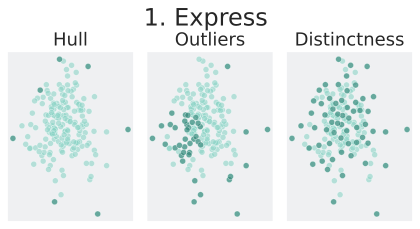

In [15]:
# Plot the three different resulting subsets as scatterplots
titleSize = 24
subtitleSize = 18
titles = ["Hull", "Outliers", "Distinctness"]
subsets = [subsetHull, subsetOutliers, subsetDistinct]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 3))
fig.text(0.49, 1, '1. Express', ha='center', va='center', fontsize=titleSize)

for i, ax in enumerate(fig.axes):
    ax.grid(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=subtitleSize)

    fss.plot.scatter(ax = ax, 
                     color = color, 
                     dataset = dataset, 
                     subset = subsets[i], 
                     alpha = 0.6)

plt.savefig(f"../figures/{directory}/express.pdf", bbox_inches="tight")

## Blend

For visualizations with multiple criteria, objectives can be combined together to achieve more complicated outcomes. Multiple criteria can be balanced using the weight parameters to ensure the objectives apply to the subsets at desirable levels. Here we create three different subsets that blend a distribution objective (using the earth movers distance as the metric) with the distinctness objective from the previous section. Each subset blends the two objectives differently by varying the weights.

\begin{align*}
\min_{S \in \mathbb{S}} & \quad \lambda_0 \text{EMD}(S) + \lambda_1 \text{Distinctness}(S) \\
\text{s.t.} & \quad \|S\| = 80
\end{align*}

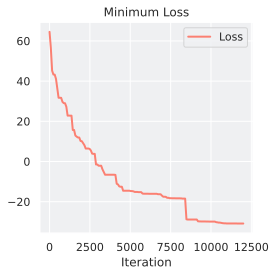

In [16]:
subsetSize = 80 # The size of subsets being selected with blended objectives

# Use distribution and distinctness objectives
objectives = [fss.objective.earthMoversDistance, fss.objective.distinctness]

# Parameters of the distribution and distinctness objectives
parameters = [{"dataset": dataset.array}, 
              {"solveArray": "distances", "selectBy": "matrix"}]

# Create the multicriterion loss function from the objectives and weight them
solver.lossFunction = fss.MultiCriterion(objectives = objectives, 
                                         parameters = parameters, 
                                         weights=[100, 1])

# Solve for the blended distribution and distinctness subset
subsetBlend1 = solver.solve(dataset, 
                            subsetSize=subsetSize, 
                            callback = fss.plot.RealTimePlotter(color).update)
subsetBlend1.save(directory = Path("..") / "data" / directory, 
                  name = "blend1Subset")

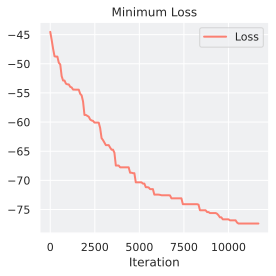

In [17]:
# Update the weights to provide less emphasis on the distribution objective
solver.lossFunction = fss.MultiCriterion(objectives = objectives, 
                                         parameters = parameters, 
                                         weights=[10, 1])

# Solve for the blended distribution and distinctness subset
subsetBlend2 = solver.solve(dataset, 
                            subsetSize=subsetSize, 
                            callback = fss.plot.RealTimePlotter(color).update)
subsetBlend2.save(directory = Path("..") / "data" / directory, 
                  name = "blend2Subset")

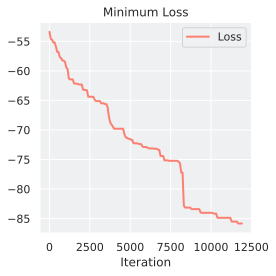

In [18]:
# Update the weights to an even weight of the two objectives
solver.lossFunction = fss.MultiCriterion(objectives = objectives, 
                                         parameters = parameters, 
                                         weights=[1, 1])

# Solve for the blended distribution and distinctness subset
subsetBlend3 = solver.solve(dataset, 
                            subsetSize=subsetSize, 
                            callback = fss.plot.RealTimePlotter(color).update)
subsetBlend3.save(directory = Path("..") / "data" / directory, 
                  name = "blend3Subset")

### Plot

Now we visualize these three example blended subsets by plotting the dataset and subsets in 3 scatterplots.

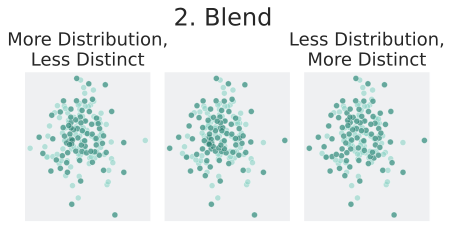

In [19]:
# Plot the three subsets with different blends of the two objectives
titles = ["More Distribution,\nLess Distinct", "", 
          "Less Distribution,\nMore Distinct"]
subsets = [subsetBlend1, subsetBlend2, subsetBlend3]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 3))
fig.text(0.49, 1, '2. Blend', ha='center', va='center', fontsize=titleSize)

for i, ax in enumerate(fig.axes):
    ax.grid(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=subtitleSize)

    fss.plot.scatter(ax = ax, 
                     color = color,
                     dataset = dataset,
                     subset = subsets[i],
                     alpha = 0.6)

plt.savefig(f"../figures/{directory}/blend.pdf", bbox_inches="tight")

## Tune

Along with the weight parameters that help in blending objectives, the parameters of the objectives and the optimization formulation can be tuned to select a subset that is more effective for a given visualization. For example, the subset size, loss bounds, and subset weight parameters can be used to tune the subset size for a particular visualization. Objectives may have parameters associated with them such as the number of clusters in a clustering objective, the amount of seperation in a distinctness objective, or the smoothing parameter of a kernel density estimation. These provide additional flexibility to tune the objectives to a desirable level. Here we tune the subset size by varying the weight given to this fundamental characteristic of a subset to three different levels. 

$$\min_{S \in \mathbb{S}} \space \lambda \|S\| + \text{Distinctness}(S)$$

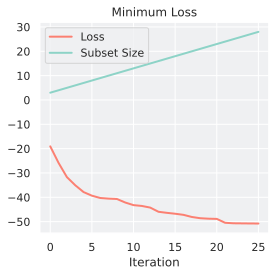

In [20]:
# Create a unicriterion loss function with the distinctness objective
solver.lossFunction = fss.UniCriterion(objective = fss.objective.distinctness,
                                       solveArray = "distances",
                                       selectBy = "matrix")
solver.algorithm = fss.algorithm.greedyMixed

# Solve for subsets with 3 different subset sizes
subsetDistinct1 = solver.solve(dataset=dataset, weight=0.5, initialSize=3, 
                            callback = fss.plot.RealTimePlotter(color).update)
subsetDistinct1.save(directory = Path("..") / "data" / directory, 
                     name = "distinct1Subset")

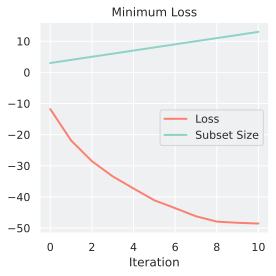

In [21]:
subsetDistinct2 = solver.solve(dataset=dataset, weight=0.25, initialSize=3, 
                            callback = fss.plot.RealTimePlotter(color).update)
subsetDistinct2.save(directory = Path("..") / "data" / directory, 
                     name = "distinct2Subset")

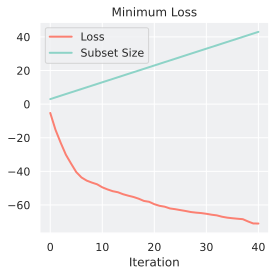

In [22]:

subsetDistinct3 = solver.solve(dataset=dataset, weight=0.05, initialSize=3, 
                            callback = fss.plot.RealTimePlotter(color).update)
subsetDistinct3.save(directory = Path("..") / "data" / directory, 
                     name = "distinct3Subset")

### Plot

Now we visualize these three example subsets of different sizes by plotting the dataset and subsets in 3 scatterplots.

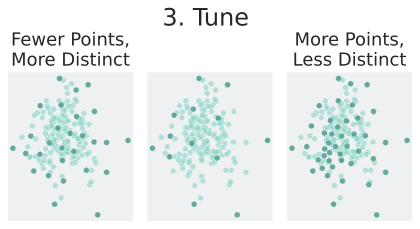

In [23]:
# Plot the three subsets with different subset sizes based on the tuning
titles = ["Fewer Points,\nMore Distinct", "", "More Points,\nLess Distinct"]
subsets = [subsetDistinct1, subsetDistinct2, subsetDistinct3]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 3))
fig.text(0.49, 1, '3. Tune', ha='center', va='center', fontsize=titleSize)

for i, ax in enumerate(fig.axes):
    ax.grid(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=subtitleSize)

    fss.plot.scatter(ax = ax, 
                 color = color, 
                 dataset = dataset, 
                 subset = subsets[i], 
                 alpha = 0.6)

plt.savefig(f"../figures/{directory}/tune.pdf", bbox_inches="tight")